In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
def get_xes_pumped(filename, DIR, DIRBS, roi, channel, ynstamp):
    numstds = 2.5
    minIzero = 0.01
    lin_filter = 0.2
    image_threshold = 2
    hot_pixel = 6

    print(DIR + filename + ".JF02T09V02crop.h5")
    print()
    print(DIRBS + filename + ".BSREAD.h5")
    
    images_off, images_on, pulse_ids_off, pulse_ids_on = \
        load_JF_cropped_data_pump(DIR + filename + ".JF02T09V02crop.h5", roi, 50, 50/3, nshots=None)
    (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, JFIDs_pump, JFIDs_unpump, Energy_pump, Energy_unpump, _, _) = \
        load_PumpProbe_events_withTwoVariables(DIRBS + filename + ".BSREAD.h5", channel_BS_pulse_ids, channel)
    (_, _, _, _, _, _, Laser_pump, Laser_unpump, _, _) = \
        load_PumpProbe_events_withTwoVariables(DIRBS + filename + ".BSREAD.h5", channel_PIPS_fluo, channel)
    
    Energy_pump = [x for x in Energy_pump if (np.abs(x) > 0)]
    Energy_eV_pump = np.mean(Energy_pump)
    
    Energy_unpump = [x for x in Energy_unpump if (np.abs(x) > 0)]
    Energy_eV_unpump = np.mean(Energy_unpump)
    
    idcheck = [a==b and c==d for a,b,c,d in zip(pulse_ids_on, JFIDs_pump, pulse_ids_off, JFIDs_unpump)]
    IDCheck = sum([int(x) for x in idcheck])
    
    if IDCheck:
        print("passed ID check")
    else:
        print("failed ID check")   
    
    IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    
    print('numon')
    print(IzeroFEL_pump.shape[0])
    
    print('numoff')
    print(IzeroFEL_unpump.shape[0])
    
    print('number of frames')
    print(images_on.shape[0])
    print(images_off.shape[0])

    images_good_on = images_on
    images_good_off = images_off

    images_thr_on = images_good_on.copy()
    images_thr_on[images_good_on < image_threshold] = 0
    images_thr_on[images_good_on > hot_pixel] = 0
    images_thr_on[np.isnan(images_thr_on)] = 0
    
    images_thr_off = images_good_off.copy()
    images_thr_off[images_good_off < image_threshold] = 0
    images_thr_off[images_good_off > hot_pixel] = 0
    images_thr_off[np.isnan(images_thr_off)] = 0
    
    print('num nan')
    print(sum(sum(sum(np.isnan(images_thr_on)))))
    
    print('Izero')
    print(np.mean(IzeroFEL_unpump))
    print(np.mean(IzeroFEL_pump))
    print(np.max(IzeroFEL_unpump))
    print(np.min(IzeroFEL_unpump))
    
    IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, condFinalPump, condFinalUnPump = \
        filterData(IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, numstds, minIzero, lin_filter)
    

    
    print(images_thr_on.shape)
    print(images_thr_on.shape)
    
    images_thr_on = images_thr_on[condFinalPump]
    images_thr_off = images_thr_off[condFinalUnPump]

    print('number of surviving frames')
    print(images_thr_on.shape[0])
    print(images_thr_off.shape[0])
    
    XES_on = images_thr_on.sum(axis=0)/images_thr_on.shape[0]
    XES_off = images_thr_off.sum(axis=0)/images_thr_off.shape[0]
    
    XES_on[np.isnan(XES_on)] = 0
    XES_off[np.isnan(XES_off)] = 0
    
    print('num nan')
    print(sum(sum(np.isnan(XES_on))))
    
    stamp = make_bar_stamp(XES_on.shape[1],XES_on.shape[0])
    
    print(XES_on.shape)
    print(stamp.shape)
    if ynstamp:

        XES_on = XES_on * stamp
        XES_off = XES_off * stamp
        
    FloFEL_pump_total = np.mean(DataFluo_pump)/np.mean(IzeroFEL_pump)
    FloFEL_unpump_total = np.mean(DataFluo_unpump)/np.mean(IzeroFEL_unpump)
    
    return XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, FloFEL_pump_total, FloFEL_unpump_total


In [4]:
def make_bar_stamp(dimension_x, dimension_y):

    X,Y = np.meshgrid(np.linspace(0,dimension_x-1,dimension_x),np.linspace(0,dimension_y-1,dimension_y))

    Z = np.zeros([dimension_y,dimension_x])+1

    condition = np.logical_and(Y<260, Y>253)
    Z[condition] = 0
    
    Z[Y>320] = 0
    Z[Y < 200] = 0

    condition = np.logical_not(np.logical_and(X<200, X>130))
    Z[condition] = 0

    #plt.figure()
    #plt.imshow(Z)
    
    #plt.colorbar()
    
    return Z

Run for RIXS

In [5]:
scannum_01 = [9]

scannum = scannum_01

for jj in range(len(scannum)):
    
    filename_base = "RuDimerACN_monoscan_0p6ps_0" + '%02d' % scannum[jj] + "_step00"
    scan_name = "RuDimerACN_monoscan_0p6ps_0" + '%02d' % scannum[jj]
    DIR = "/das/work/p17/p17983/cropped_data/scan_data/" + scan_name + "/"
    DIRBS = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
    numfiles = 54+1

#     filename_base = "RuBpy3_monoscan_0" + '%02d' % scannum[jj] + "_step00"
#     scan_name = "RuBpy3_monoscan_0" + '%02d' % scannum[jj]
#     DIR = "/das/work/p17/p17983/cropped_data/scan_data/" + scan_name + "/"
#     DIRBS = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
#     numfiles = 35+1

    eV_on_01 = np.empty(numfiles)
    eV_off_01 = np.empty(numfiles)
    
    fluo_Pump = np.empty(numfiles)
    fluo_Unpump = np.empty(numfiles)
    

    for ii in range(numfiles):

        XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, fluo_pump, fluo_unpump = \
            get_xes_pumped(filename_base + '%02d' % (ii+0), DIR, DIRBS, 2, channel_energy, True)

        if False:

            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(XES_on, vmax = 0.001)
            plt.colorbar()
            plt.subplot(1,2,2)
            plt.imshow(XES_off, vmax = 0.001)
            plt.colorbar()
            plt.tight_layout()
        
        
        if ii == 0 & jj == 0:
            rixs_on_01 = XES_on.sum(axis=0)
            rixs_off_01 = XES_off.sum(axis=0)
        else:
            rixs_on_01 = np.vstack((rixs_on_01,XES_on.sum(axis=0)))
            rixs_off_01 = np.vstack((rixs_off_01,XES_off.sum(axis=0)))
            
        eV_on_01[ii] = Energy_eV_pump
        eV_off_01[ii] = Energy_eV_unpump
        fluo_Pump[ii] = fluo_pump
        fluo_Unpump[ii] = fluo_unpump
            
        
    if jj == 0:
        
        RIXS_on_01 = rixs_on_01
        RIXS_off_01 = rixs_off_01
        Fluo_pump_01 = fluo_Pump
        Fluo_unpump_01 = fluo_Unpump
        
    else:
        
        RIXS_on_01 = RIXS_on_01 + rixs_on_01
        RIXS_off_01 = RIXS_off_01 + rixs_off_01
        Fluo_pump_01 = Fluo_pump_01 + fluo_Pump
        Fluo_unpump_01 = Fluo_unpump_01 + fluo_Unpump



/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_0p6ps_009/RuDimerACN_monoscan_0p6ps_009_step0000.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_009/RuDimerACN_monoscan_0p6ps_009_step0000.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.05036514413238198
0.054107195115473676
0.13214048743247986
0.011370232328772545
(667, 512, 300)
(667, 512, 300)
number of surviving frames
648
324
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_0p6ps_009/RuDimerACN_monoscan_0p6ps_009_step0001.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_009/RuDimerACN_monoscan_0p6ps_009_step0001.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0

SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.05187108649245768
0.053875576888875704
0.1433250457048416
-0.00044039380736649036
(667, 512, 300)
(667, 512, 300)
number of surviving frames
645
322
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_0p6ps_009/RuDimerACN_monoscan_0p6ps_009_step0015.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_009/RuDimerACN_monoscan_0p6ps_009_step0015.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.05075247431392068
0.052803121146838834
0.13875967264175415
0.007814329117536545
(667, 512, 300)
(667, 512, 300)
number of surviving frames
645
329
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_0p6ps_009/RuD

SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
666
numoff
334
number of frames
666
334
num nan
0
Izero
0.05122268507989928
0.05008650315852851
0.16792474687099457
-7.586892752442509e-05
(666, 512, 300)
(666, 512, 300)
number of surviving frames
629
320
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_0p6ps_009/RuDimerACN_monoscan_0p6ps_009_step0029.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_009/RuDimerACN_monoscan_0p6ps_009_step0029.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.049988520471519
0.05116163567703418
0.16434068977832794
0.003421088680624962
(667, 512, 300)
(667, 512, 300)
number of surviving frames
645
320
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_0p6ps_009/RuDimer

SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.04307172883310014
0.04420607300673818
0.12634366750717163
0.00027682926156558096
(667, 512, 300)
(667, 512, 300)
number of surviving frames
609
292
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_0p6ps_009/RuDimerACN_monoscan_0p6ps_009_step0043.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_0p6ps_009/RuDimerACN_monoscan_0p6ps_009_step0043.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.04572183459964851
0.04492332521324064
0.1266140639781952
-1.9696663002832793e-06
(667, 512, 300)
(667, 512, 300)
number of surviving frames
607
298
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_0p6ps_009/RuD

In [6]:
scannum_02 = [8,13]

scannum = scannum_02

for jj in range(len(scannum)):
    
    filename_base = "RuDimerACN_monoscan_10ps_0" + '%02d' % scannum[jj] + "_step00"
    scan_name = "RuDimerACN_monoscan_10ps_0" + '%02d' % scannum[jj]
    DIR = "/das/work/p17/p17983/cropped_data/scan_data/" + scan_name + "/"
    DIRBS = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
    numfiles = 54+1
    #numfiles = 3

    eV_on_02 = np.empty(numfiles)
    eV_off_02 = np.empty(numfiles)
    
    fluo_Pump = np.empty(numfiles)
    fluo_Unpump = np.empty(numfiles)
    

    for ii in range(numfiles):

        XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, fluo_pump, fluo_unpump = \
            get_xes_pumped(filename_base + '%02d' % (ii+0), DIR, DIRBS, 2, channel_energy, True)

        if False:

            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(XES_on, vmax = 0.001)
            plt.colorbar()
            plt.subplot(1,2,2)
            plt.imshow(XES_off, vmax = 0.001)
            plt.colorbar()
            plt.tight_layout()
        
        
        if ii == 0 & jj == 0:
            rixs_on_02 = XES_on.sum(axis=0)
            rixs_off_02 = XES_off.sum(axis=0)
        else:
            rixs_on_02 = np.vstack((rixs_on_02,XES_on.sum(axis=0)))
            rixs_off_02 = np.vstack((rixs_off_02,XES_off.sum(axis=0)))
            
        eV_on_02[ii] = Energy_eV_pump
        eV_off_02[ii] = Energy_eV_unpump
        fluo_Pump[ii] = fluo_pump
        fluo_Unpump[ii] = fluo_unpump
            
        
    if jj == 0:
        
        RIXS_on_02 = rixs_on_02
        RIXS_off_02 = rixs_off_02
        Fluo_pump_02 = fluo_Pump
        Fluo_unpump_02 = fluo_Unpump
        
    else:
        
        RIXS_on_02 = RIXS_on_02 + rixs_on_02
        RIXS_off_02 = RIXS_off_02 + rixs_off_02
        Fluo_pump_02 = Fluo_pump_02 + fluo_Pump
        Fluo_unpump_02 = Fluo_unpump_02 + fluo_Unpump

/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0000.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0000.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
666
numoff
334
number of frames
666
334
num nan
0
Izero
0.05004137819923926
0.05112526036502497
0.12206646054983139
-0.0003963132912758738
(666, 512, 300)
(666, 512, 300)
number of surviving frames
639
330
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0001.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0001.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.052833

SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.05083417623127635
0.050903507917449214
0.16214656829833984
0.01334068551659584
(667, 512, 300)
(667, 512, 300)
number of surviving frames
647
325
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0015.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0015.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.05194872768607002
0.05196831040531173
0.1357831507921219
0.007744582835584879
(667, 512, 300)
(667, 512, 300)
number of surviving frames
638
324
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_mo

SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.05045337413714544
0.048857074962563064
0.1542891263961792
0.011090331710875034
(667, 512, 300)
(667, 512, 300)
number of surviving frames
652
316
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0029.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0029.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.04996008845465677
0.0499976812853133
0.12357232719659805
0.008444992825388908
(667, 512, 300)
(667, 512, 300)
number of surviving frames
644
322
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0030.JF02T09V02c

SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
666
numoff
334
number of frames
666
334
num nan
0
Izero
0.05169063729853063
0.05183006500036599
0.1539187878370285
0.013199218548834324
(666, 512, 300)
(666, 512, 300)
number of surviving frames
644
324
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0043.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0043.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.051529723571791024
0.05068080083814742
0.11933913826942444
0.00030602322658523917
(667, 512, 300)
(667, 512, 300)
number of surviving frames
648
324
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_008/RuDimerACN_monoscan_10ps_008_step0044.JF02T09V

num nan
0
Izero
0.057724997381718754
0.05795220243003409
0.146882101893425
0.014805172570049763
(666, 512, 300)
(666, 512, 300)
number of surviving frames
646
325
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0002.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0002.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
666
numoff
334
number of frames
666
334
num nan
0
Izero
0.058936929176868255
0.05819938465789962
0.14818651974201202
0.006121405400335789
(666, 512, 300)
(666, 512, 300)
number of surviving frames
643
322
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0003.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps

number of surviving frames
648
319
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0016.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0016.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.06015841825655452
0.05604805545867428
0.15234781801700592
0.01144472323358059
(667, 512, 300)
(667, 512, 300)
number of surviving frames
654
323
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0017.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0017.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon


SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.057544724987791826
0.058829594036282185
0.15096688270568848
0.01551135629415512
(667, 512, 300)
(667, 512, 300)
number of surviving frames
645
328
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0031.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0031.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
666
numoff
334
number of frames
666
334
num nan
0
Izero
0.05578519526344841
0.05716258476980523
0.19590674340724945
0.01522385235875845
(666, 512, 300)
(666, 512, 300)
number of surviving frames
648
325
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_m

num nan
0
Izero
0.05791408330616024
0.058108889466465585
0.14085514843463898
0.014721301384270191
(667, 512, 300)
(667, 512, 300)
number of surviving frames
652
323
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0045.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0045.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
667
numoff
333
number of frames
667
333
num nan
0
Izero
0.05555199035764993
0.055319322798662224
0.15868565440177917
0.01225762628018856
(667, 512, 300)
(667, 512, 300)
number of surviving frames
646
322
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10ps_013_step0046.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_monoscan_10ps_013/RuDimerACN_monoscan_10p

<IPython.core.display.Javascript object>


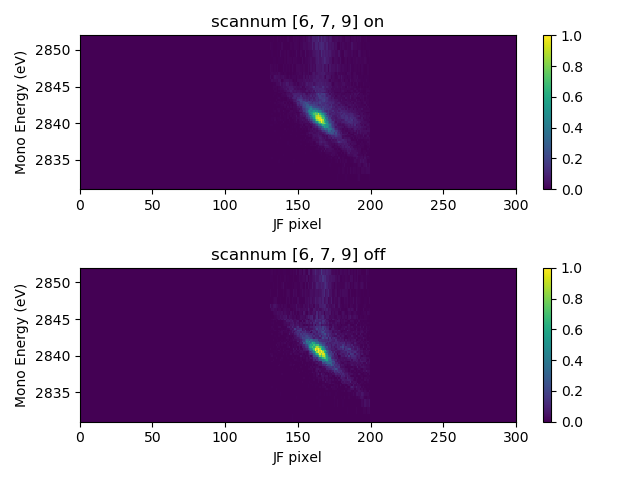

<IPython.core.display.Javascript object>


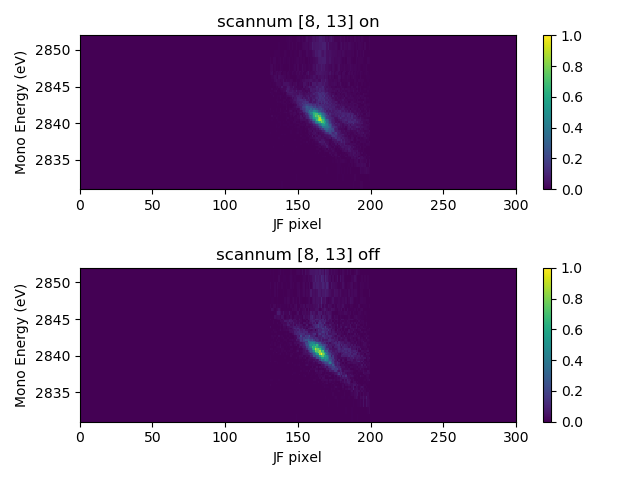

In [11]:
X,Y = np.meshgrid(np.linspace(0,RIXS_on_01.shape[1],RIXS_on_01.shape[1]+1),eV_on_01)
plt.figure()
plt.subplot(2,1,1)
plt.pcolor(X,Y,RIXS_on_01, vmax = 1)
plt.colorbar()
plt.xlabel('JF pixel')
plt.ylabel('Mono Energy (eV)')
plt.title('scannum ' + str(scannum_01) + ' on')

X,Y = np.meshgrid(np.linspace(0,RIXS_off_01.shape[1],RIXS_off_01.shape[1]+1),eV_off_01)
plt.subplot(2,1,2)
plt.pcolor(X,Y,RIXS_off_01, vmax = 1)
plt.colorbar()
plt.xlabel('JF pixel')
plt.ylabel('Mono Energy (eV)')
plt.title('scannum ' + str(scannum_01) + ' off')

plt.tight_layout()


X,Y = np.meshgrid(np.linspace(0,RIXS_on_02.shape[1],RIXS_on_02.shape[1]+1),eV_on_02)
plt.figure()
plt.subplot(2,1,1)
plt.pcolor(X,Y,RIXS_on_02, vmax = 1)
plt.colorbar()
plt.xlabel('JF pixel')
plt.ylabel('Mono Energy (eV)')
plt.title('scannum ' + str(scannum_02) + ' on')

X,Y = np.meshgrid(np.linspace(0,RIXS_off_02.shape[1],RIXS_off_02.shape[1]+1),eV_off_02)
plt.subplot(2,1,2)
plt.pcolor(X,Y,RIXS_off_02, vmax = 1)
plt.colorbar()
plt.xlabel('JF pixel')
plt.ylabel('Mono Energy (eV)')
plt.title('scannum ' + str(scannum_02) + ' off')

plt.tight_layout()

<IPython.core.display.Javascript object>


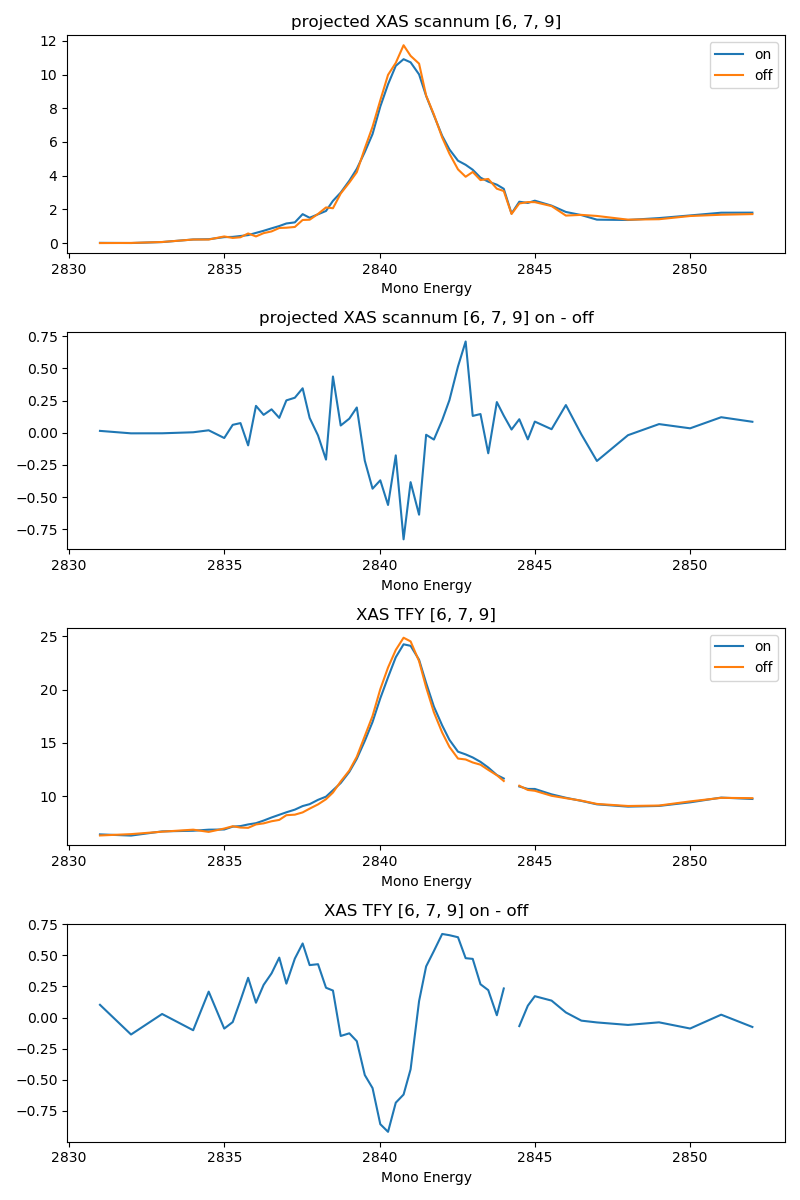

<IPython.core.display.Javascript object>


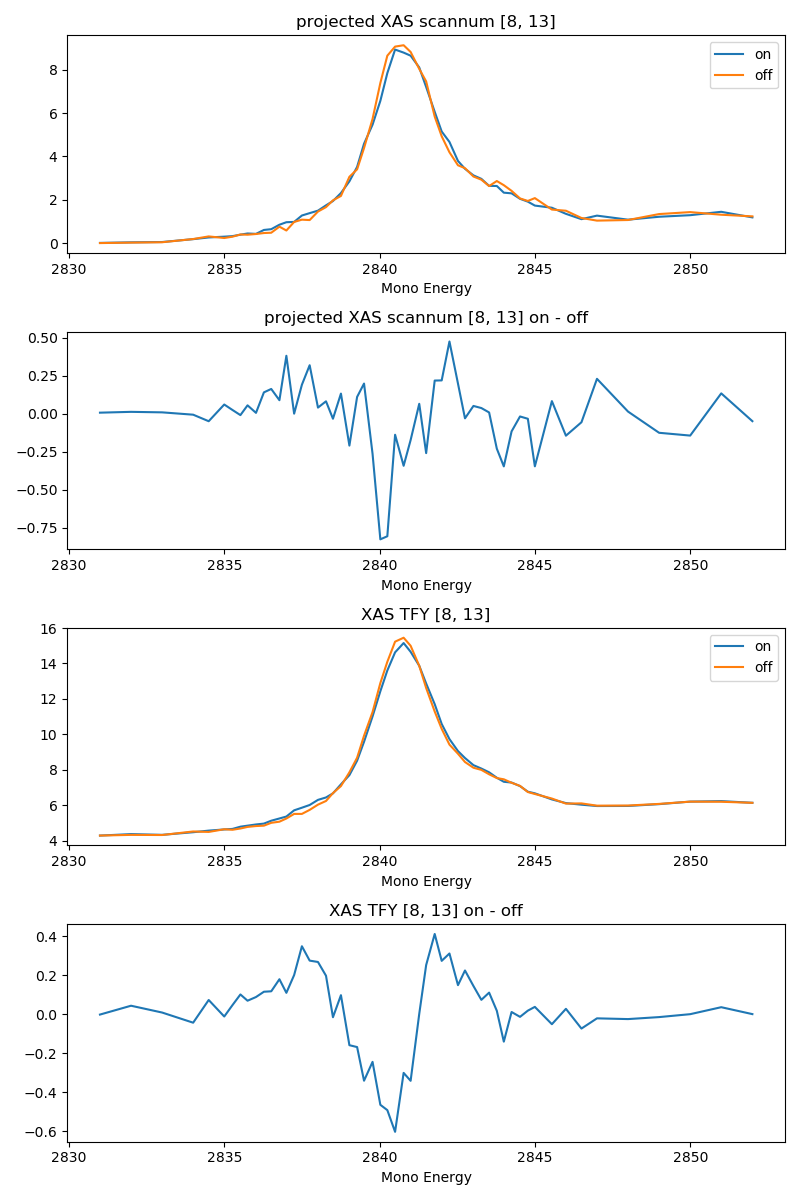

In [12]:
plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
plt.plot(eV_on_01, RIXS_on_01.sum(axis=1), label = "on")
plt.plot(eV_off_01, RIXS_off_01.sum(axis=1), label = 'off')
plt.xlabel('Mono Energy')
plt.title('projected XAS scannum ' + str(scannum_01))
plt.legend()

plt.subplot(4,1,2)
plt.plot(eV_off_01, RIXS_on_01.sum(axis=1)-RIXS_off_01.sum(axis=1))
plt.xlabel('Mono Energy')
plt.title('projected XAS scannum ' + str(scannum_01) + ' on - off')

plt.subplot(4,1,3)
plt.plot(eV_on_01, Fluo_pump_01, label = "on")
plt.plot(eV_off_01, Fluo_unpump_01, label = 'off')
plt.xlabel('Mono Energy')
plt.title('XAS TFY ' + str(scannum_01))
plt.legend()

plt.subplot(4,1,4)
plt.plot(eV_off_01, Fluo_pump_01-Fluo_unpump_01)
plt.xlabel('Mono Energy')
plt.title('XAS TFY ' + str(scannum_01) + ' on - off')


plt.tight_layout()


plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
plt.plot(eV_on_02, RIXS_on_02.sum(axis=1), label = "on")
plt.plot(eV_off_02, RIXS_off_02.sum(axis=1), label = 'off')
plt.xlabel('Mono Energy')
plt.title('projected XAS scannum ' + str(scannum_02))
plt.legend()

plt.subplot(4,1,2)
plt.plot(eV_off_02, RIXS_on_02.sum(axis=1)-RIXS_off_02.sum(axis=1))
plt.xlabel('Mono Energy')
plt.title('projected XAS scannum ' + str(scannum_02) + ' on - off')

plt.subplot(4,1,3)
plt.plot(eV_on_02, Fluo_pump_02, label = "on")
plt.plot(eV_off_02, Fluo_unpump_02, label = 'off')
plt.xlabel('Mono Energy')
plt.title('XAS TFY ' + str(scannum_02))
plt.legend()

plt.subplot(4,1,4)
plt.plot(eV_off_02, Fluo_pump_02-Fluo_unpump_02)
plt.xlabel('Mono Energy')
plt.title('XAS TFY ' + str(scannum_02) + ' on - off')

plt.tight_layout()

<IPython.core.display.Javascript object>


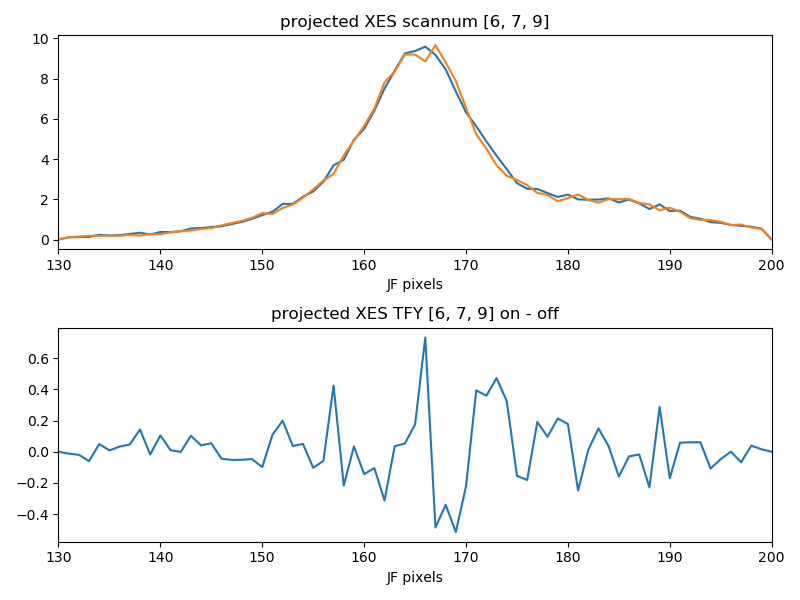

<IPython.core.display.Javascript object>


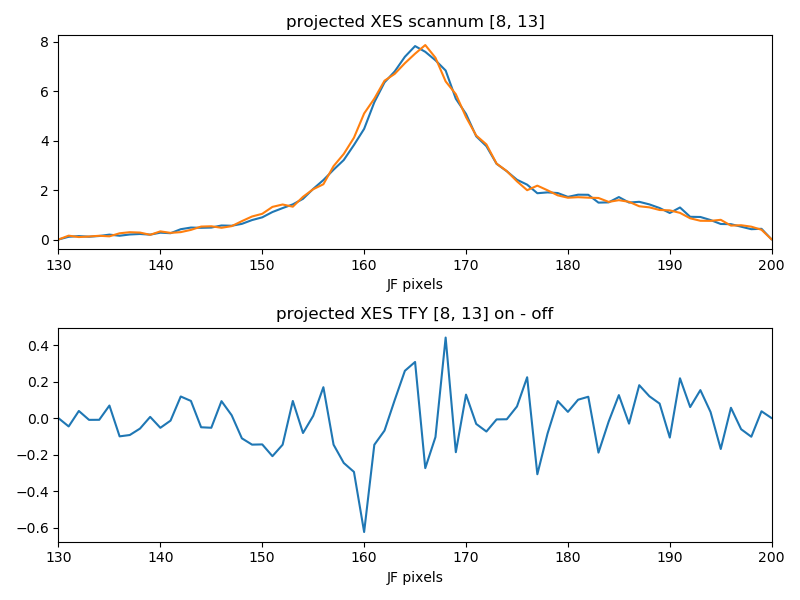

In [13]:
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(RIXS_on_01.sum(axis=0), label = "on")
plt.plot(RIXS_off_01.sum(axis=0), label = "off")
plt.xlabel('JF pixels')
plt.title('projected XES scannum ' + str(scannum_01))
plt.xlim([130,200])

plt.subplot(2,1,2)
plt.plot(RIXS_on_01.sum(axis=0) - RIXS_off_01.sum(axis=0))
plt.xlabel('JF pixels')
plt.title('projected XES TFY ' + str(scannum_01) + ' on - off')
plt.xlim([130,200])

plt.tight_layout()

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(RIXS_on_02.sum(axis=0), label = "on")
plt.plot(RIXS_off_02.sum(axis=0), label = "off")
plt.xlabel('JF pixels')
plt.title('projected XES scannum ' + str(scannum_02))
plt.xlim([130,200])

plt.subplot(2,1,2)
plt.plot(RIXS_on_02.sum(axis=0) - RIXS_off_02.sum(axis=0))
plt.xlabel('JF pixels')
plt.title('projected XES TFY ' + str(scannum_02) + ' on - off')
plt.xlim([130,200])

plt.tight_layout()

In [6]:
pixel_range_max = 168
pixel_range_min = 167


plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
plt.plot(eV_on_01p, RIXS_on_01p[:,pixel_range_min:pixel_range_max].sum(axis=1), label = "on")
plt.plot(eV_off_01p, (RIXS_off_01p[:,pixel_range_min:pixel_range_max].sum(axis=1)+RIXS_off_02p[:,pixel_range_min:pixel_range_max].sum(axis=1))/2, label = 'off')
plt.xlabel('Mono Energy')
plt.title('HERFD scannum ' + str(scannum_01))
plt.legend()

plt.subplot(4,1,2)
plt.plot(eV_off_01p, RIXS_on_01p[:,pixel_range_min:pixel_range_max].sum(axis=1)-\
         (RIXS_off_01p[:,pixel_range_min:pixel_range_max].sum(axis=1)+RIXS_off_02p[:,pixel_range_min:pixel_range_max].sum(axis=1))/2)
plt.xlabel('Mono Energy')
plt.title('HERFD scannum ' + str(scannum_01) + ' on - off')

plt.subplot(4,1,3)
plt.plot(eV_on_01p, Fluo_pump_01p, label = "on")
plt.plot(eV_off_01p, Fluo_unpump_01p, label = 'off')
plt.xlabel('Mono Energy')
plt.title('XAS TFY ' + str(scannum_01))
plt.legend()

plt.subplot(4,1,4)
plt.plot(eV_off_01p, Fluo_pump_01p-Fluo_unpump_01p)
plt.xlabel('Mono Energy')
plt.title('XAS TFY ' + str(scannum_01) + ' on - off')


plt.tight_layout()


plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
plt.plot(eV_on_02p, RIXS_on_02p[:,pixel_range_min:pixel_range_max].sum(axis=1), label = "on")
plt.plot(eV_off_02p, (RIXS_off_01p[:,pixel_range_min:pixel_range_max].sum(axis=1)+RIXS_off_02p[:,pixel_range_min:pixel_range_max].sum(axis=1))/2, label = 'off')
plt.xlabel('Mono Energy')
plt.title('constant emission energy scannum ' + str(scannum_02))
plt.legend()

plt.subplot(4,1,2)
plt.plot(eV_off_02p, RIXS_on_02p[:,pixel_range_min:pixel_range_max].sum(axis=1)-\
         (RIXS_off_01p[:,pixel_range_min:pixel_range_max].sum(axis=1)+RIXS_off_02p[:,pixel_range_min:pixel_range_max].sum(axis=1))/2)
plt.xlabel('Mono Energy')
plt.title('constant emission energy scannum ' + str(scannum_02) + ' on - off')

plt.subplot(4,1,3)
plt.plot(eV_on_02p, Fluo_pump_02p, label = "on")
plt.plot(eV_off_02p, Fluo_unpump_02p, label = 'off')
plt.xlabel('Mono Energy')
plt.title('XAS TFY ' + str(scannum_02))
plt.legend()

plt.subplot(4,1,4)
plt.plot(eV_off_02p, Fluo_pump_02p-Fluo_unpump_02p)
plt.xlabel('Mono Energy')
plt.title('XAS TFY ' + str(scannum_02) + ' on - off')

plt.tight_layout()

<IPython.core.display.Javascript object>

NameError: name 'eV_on_01p' is not defined

mono_max
2852.001594791198
mono_min
2845.536242825022


<IPython.core.display.Javascript object>


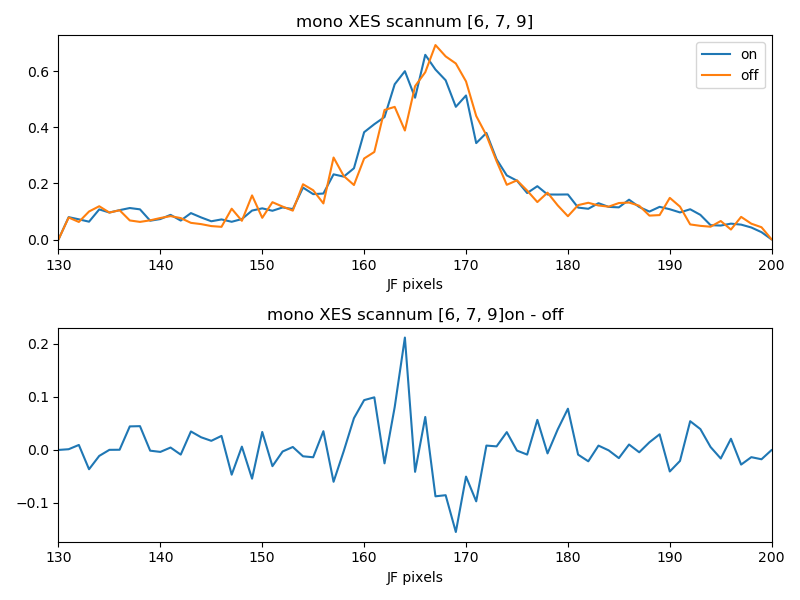

mono_max
2851.99933200511
mono_min
2845.544913405147


<IPython.core.display.Javascript object>


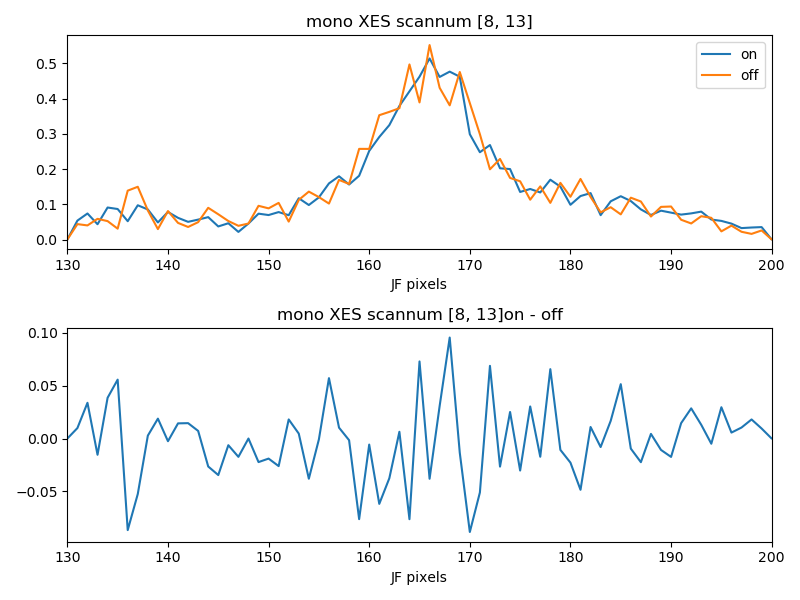

<IPython.core.display.Javascript object>


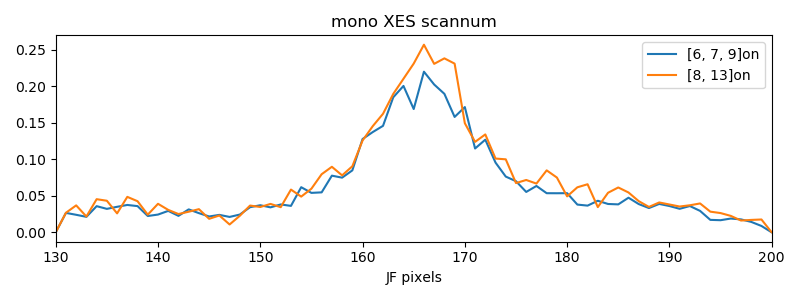

<IPython.core.display.Javascript object>


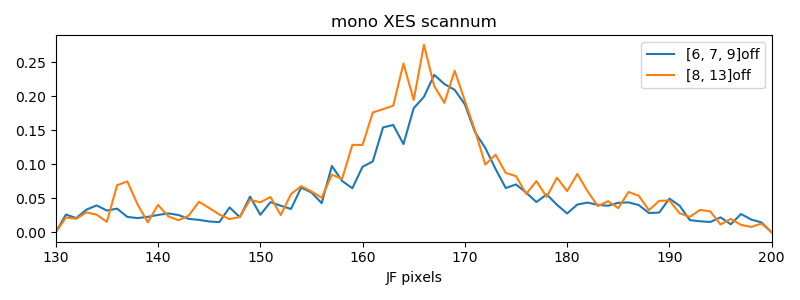

0
8


In [35]:
mono_range_min = 2845
mono_range_max = 2860



index_min = min(min(np.where(eV_on_01 < mono_range_max)))
index_max = max(max(np.where(eV_on_01 > mono_range_min)))

print('mono_max')
print(eV_on_01[index_min])
print('mono_min')
print(eV_on_01[index_max])

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(RIXS_on_01[index_min:index_max].sum(axis=0), label = "on")
plt.plot((RIXS_off_01[index_min:index_max].sum(axis=0)), label = "off")
#plt.plot(RIXS_off_01[index_min:index_max].sum(axis=0), label = "off")
plt.xlabel('JF pixels')
plt.title('mono XES scannum ' + str(scannum_01))
plt.xlim([130,200])
plt.legend()

plt.subplot(2,1,2)
plt.plot(RIXS_on_01[index_min:index_max].sum(axis=0) - (RIXS_off_01[index_min:index_max].sum(axis=0)))
plt.xlabel('JF pixels')
plt.title('mono XES scannum ' + str(scannum_01) + 'on - off')
plt.xlim([130,200])

plt.tight_layout()

index_min = min(min(np.where(eV_on_02 < mono_range_max)))
index_max = max(max(np.where(eV_on_02 > mono_range_min)))

print('mono_max')
print(eV_on_02[index_min])
print('mono_min')
print(eV_on_02[index_max])

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(RIXS_on_02[index_min:index_max].sum(axis=0), label = "on")
plt.plot((RIXS_off_02[index_min:index_max].sum(axis=0)), label = "off")
plt.xlabel('JF pixels')
plt.title('mono XES scannum ' + str(scannum_02))
plt.xlim([130,200])
plt.legend()

plt.subplot(2,1,2)
plt.plot(RIXS_on_02[index_min:index_max].sum(axis=0) - (RIXS_off_02[index_min:index_max].sum(axis=0)))
plt.xlabel('JF pixels')
plt.title('mono XES scannum ' + str(scannum_02) + 'on - off')
plt.xlim([130,200])

plt.tight_layout()

plt.figure(figsize=(8,3))
plt.plot((RIXS_on_01[index_min:index_max].sum(axis=0))/3, label = str(scannum_01) + "on")
plt.plot((RIXS_on_02[index_min:index_max].sum(axis=0))/2, label = str(scannum_02) + "on")
plt.xlabel('JF pixels')
plt.title('mono XES scannum')
plt.xlim([130,200])
plt.legend()
plt.tight_layout()

plt.figure(figsize=(8,3))
plt.plot((RIXS_off_01[index_min:index_max].sum(axis=0))/3, label = str(scannum_01) + "off")
plt.plot((RIXS_off_02[index_min:index_max].sum(axis=0))/2, label = str(scannum_02) + "off")
plt.xlabel('JF pixels')
plt.title('mono XES scannum')
plt.xlim([130,200])
plt.legend()
plt.tight_layout()


print(index_min)
print(index_max)

In [27]:
if True:
    np.save('/das/work/p17/p17983/Reduced_data/ACN_RIXS_0p6ps_on_scan_06_07_09.npy', RIXS_on_01)
    np.save('/das/work/p17/p17983/Reduced_data/ACN_RIXS_0p6ps_off_scan_06_07_09.npy', RIXS_off_01)
    np.save('/das/work/p17/p17983/Reduced_data/ACN_RIXS_10ps_on_scan_05_08_10.npy', RIXS_on_02)
    np.save('/das/work/p17/p17983/Reduced_data/ACN_RIXS_10ps_off_scan_05_08_10.npy', RIXS_off_02)
    np.save('/das/work/p17/p17983/Reduced_data/eV_0p6ps_on_scan_06_07_09.npy', eV_on_01)
    np.save('/das/work/p17/p17983/Reduced_data/eV_0p6ps_off_scan_06_07_09.npy', eV_off_01)
    np.save('/das/work/p17/p17983/Reduced_data/eV_10ps_on_scan_05_08_10.npy', eV_on_02)
    np.save('/das/work/p17/p17983/Reduced_data/eV_10ps_off_scan_05_08_10.npy', eV_off_02)
    np.save('/das/work/p17/p17983/Reduced_data/Fluo_10ps_on_scan_06_07_09.npy', Fluo_pump_01)
    np.save('/das/work/p17/p17983/Reduced_data/Fluo_10ps_off_scan_06_07_09.npy', Fluo_unpump_01)
    np.save('/das/work/p17/p17983/Reduced_data/Fluo_10ps_on_scan_05_08_10.npy', Fluo_pump_02)
    np.save('/das/work/p17/p17983/Reduced_data/Fluo_10ps_off_scan_05_08_10.npy', Fluo_unpump_02)

In [28]:
if True:
    RIXS_on_01p = np.load('/das/work/p17/p17983/Reduced_data/ACN_RIXS_0p6ps_on_scan_06_07_09.npy')
    RIXS_off_01p = np.load('/das/work/p17/p17983/Reduced_data/ACN_RIXS_0p6ps_off_scan_06_07_09.npy')
    RIXS_on_02p = np.load('/das/work/p17/p17983/Reduced_data/ACN_RIXS_10ps_on_scan_05_08_10.npy')
    RIXS_off_02p = np.load('/das/work/p17/p17983/Reduced_data/ACN_RIXS_10ps_off_scan_05_08_10.npy')
    eV_on_01p = np.load('/das/work/p17/p17983/Reduced_data/eV_0p6ps_on_scan_06_07_09.npy')
    eV_off_01p = np.load('/das/work/p17/p17983/Reduced_data/eV_0p6ps_off_scan_06_07_09.npy')
    eV_on_02p = np.load('/das/work/p17/p17983/Reduced_data/eV_10ps_on_scan_05_08_10.npy')
    eV_off_02p = np.load('/das/work/p17/p17983/Reduced_data/eV_10ps_off_scan_05_08_10.npy')
    Fluo_pump_01p = np.load('/das/work/p17/p17983/Reduced_data/Fluo_10ps_on_scan_06_07_09.npy')
    Fluo_unpump_01p = np.load('/das/work/p17/p17983/Reduced_data/Fluo_10ps_off_scan_06_07_09.npy')
    Fluo_pump_02p = np.load('/das/work/p17/p17983/Reduced_data/Fluo_10ps_on_scan_05_08_10.npy')
    Fluo_unpump_02p = np.load('/das/work/p17/p17983/Reduced_data/Fluo_10ps_off_scan_05_08_10.npy')